In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import gower

### PRE PROCESSAMENTO

In [3]:
file_path = 'adult_data/adult.data'

columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]

df = pd.read_csv(file_path, header=None, names=columns, skipinitialspace=True)

display(df.head(10))


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [4]:
# Verifica dados ausentes (valores NaN)
print(df.isnull().sum())

# Também verifica se há valores representando ausência como '?'
print(df.eq('?').sum())


age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64
age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
income               0
dtype: int64


In [68]:
categorical_columns = [
    'workclass', 'education', 'marital-status',
    'occupation', 'relationship', 'race',
    'sex', 'native-country'
]


print("Variáveis categóricas e número de categorias distintas\n")
for col in categorical_columns:
    print(f"{col:<15}: {df[col].nunique()}")


Variáveis categóricas e número de categorias distintas

workclass      : 9
education      : 16
marital-status : 7
occupation     : 15
relationship   : 6
race           : 5
sex            : 2
native-country : 42


In [69]:
def analisar_balanceamento_categoricas(df, colunas_categoricas):
    for col in colunas_categoricas:
        dist = df[col].value_counts(normalize=True).sort_values(ascending=False)
        n_categorias = dist.size
        max_freq = dist.max() * 100
        min_freq = dist.min() * 100
        razao = dist.max() / dist.min()
        
        print(f"\nVariável: '{col}'")
        print(f"Total de categorias: {n_categorias}")
        print(f"Categoria mais frequente: {dist.idxmax()} ({max_freq:.2f}%)")
        print(f"Categoria menos frequente: {dist.idxmin()} ({min_freq:.4f}%)")
        print(f"Razão max/min: {razao:.2f}x")
        print("Distribuição (top 10 categorias):")
        print(dist.head(10).apply(lambda x: f"{x*100:.2f}%"))
        print("-" * 40)

categoricas = [
    'workclass', 'education', 'marital-status', 'occupation', 
    'relationship', 'race', 'sex', 'native-country', 'income'
]

analisar_balanceamento_categoricas(df, categoricas)



Variável: 'workclass'
Total de categorias: 9
Categoria mais frequente: Private (69.70%)
Categoria menos frequente: Never-worked (0.0215%)
Razão max/min: 3242.29x
Distribuição (top 10 categorias):
workclass
Private             69.70%
Self-emp-not-inc     7.80%
Local-gov            6.43%
?                    5.64%
State-gov            3.99%
Self-emp-inc         3.43%
Federal-gov          2.95%
Without-pay          0.04%
Never-worked         0.02%
Name: proportion, dtype: object
----------------------------------------

Variável: 'education'
Total de categorias: 16
Categoria mais frequente: HS-grad (32.25%)
Categoria menos frequente: Preschool (0.1566%)
Razão max/min: 205.90x
Distribuição (top 10 categorias):
education
HS-grad         32.25%
Some-college    22.39%
Bachelors       16.45%
Masters          5.29%
Assoc-voc        4.24%
11th             3.61%
Assoc-acdm       3.28%
10th             2.87%
7th-8th          1.98%
Prof-school      1.77%
Name: proportion, dtype: object
-----------

#### IMPUTANDO EDUCATION

In [70]:
# 1. Carrega dados
file_path = 'adult_data/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]
df = pd.read_csv(file_path, header=None, names=columns, skipinitialspace=True)

# 2. Prepara coluna categórica e salva original
df['education_original'] = df['education'].copy()

# 3. Gera valores ausentes (MCAR)
np.random.seed(42)
missing_mask = df.sample(frac=0.10).index
df.loc[missing_mask, 'education'] = np.nan

# 4. Prepara dados com variáveis mistas
features = [
    'age', 'hours-per-week', 'capital-gain', 'capital-loss',
    'workclass', 'marital-status', 'occupation', 'relationship',
    'race', 'sex', 'native-country'
]
df_knn = df[features + ['education']].copy()

# 5. Separa conjuntos
df_complete = df_knn.dropna(subset=['education'])
df_missing = df_knn[df_knn['education'].isna()]

# 6. Calcula matriz de distância de Gower
X_complete = df_complete.drop(columns='education')
X_missing = df_missing.drop(columns='education')

distance_matrix = gower.gower_matrix(X_missing, X_complete)

# 7. Aplica "KNN" com distância de Gower (moda dos vizinhos mais próximos)
k = 5
indices = np.argsort(distance_matrix, axis=1)[:, :k]
y_complete = df_complete['education'].reset_index(drop=True)

imputed_education = []
for neighbor_idxs in indices:
    neighbor_values = y_complete.iloc[neighbor_idxs]
    moda = neighbor_values.mode().iloc[0]
    imputed_education.append(moda)

# 8. Avaliação
original_values = df.loc[missing_mask, 'education_original']
imputed_values = pd.Series(imputed_education, index=missing_mask)

accuracy_knn = accuracy_score(original_values, imputed_values) * 100

# 9. Baselines
num_classes = df['education_original'].nunique()
accuracy_random = 100 / num_classes

most_frequent = df['education_original'].mode()[0]
accuracy_moda = accuracy_score(original_values, [most_frequent]*len(original_values)) * 100

# 10. Resultados
print(f"Acurácia imputação com KNN (Gower + moda): {accuracy_knn:.2f}%")
print(f"Acurácia da imputação aleatória (1/{num_classes}): {accuracy_random:.2f}%")
print(f"Acurácia da imputação pela moda global: {accuracy_moda:.2f}%")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_random:.2f}x melhor que o acaso.")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_moda:.2f}x melhor que a moda.")

# 11. Armazena resultados
results = []

results.append({
    'variavel': 'education',
    'metodo': 'KNN_Gower',
    'acuracia': accuracy_knn,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'education',
    'metodo': 'Aleatória',
    'acuracia': accuracy_random,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'education',
    'metodo': 'Moda',
    'acuracia': accuracy_moda,
    'num_categorias': num_classes
})

Acurácia imputação com KNN (Gower + moda): 20.33%
Acurácia da imputação aleatória (1/16): 6.25%
Acurácia da imputação pela moda global: 31.70%
➡️ KNN (Gower) é 3.25x melhor que o acaso.
➡️ KNN (Gower) é 0.64x melhor que a moda.


### IMPUTANDO NATIVE COUNTRY

In [75]:
# 1. Carrega dados
file_path = 'adult_data/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]
df = pd.read_csv(file_path, header=None, names=columns, skipinitialspace=True)

# 2. Prepara coluna categórica e salva original
df['native_country_original'] = df['native-country'].copy()

# 3. Gera valores ausentes (MCAR)
np.random.seed(42)
missing_mask = df.sample(frac=0.10).index
df.loc[missing_mask, 'native-country'] = np.nan

# 4. Prepara dados com variáveis mistas
features = [
    'age', 'hours-per-week', 'capital-gain', 'capital-loss',
    'workclass', 'marital-status', 'occupation', 'relationship',
    'race', 'sex', 'education'
]
df_knn = df[features + ['native-country']].copy()

# 5. Separa conjuntos
df_complete = df_knn.dropna(subset=['native-country'])
df_missing = df_knn[df_knn['native-country'].isna()]

# 6. Calcula matriz de distância de Gower
X_complete = df_complete.drop(columns='native-country')
X_missing = df_missing.drop(columns='native-country')

distance_matrix = gower.gower_matrix(X_missing, X_complete)

# 7. Aplica "KNN" com distância de Gower (moda dos vizinhos mais próximos)
k = 10
indices = np.argsort(distance_matrix, axis=1)[:, :k]
y_complete = df_complete['native-country'].reset_index(drop=True)

imputed_country = []
for neighbor_idxs in indices:
    neighbor_values = y_complete.iloc[neighbor_idxs]
    moda = neighbor_values.mode().iloc[0]
    imputed_country.append(moda)

# 8. Avaliação
original_values = df.loc[missing_mask, 'native_country_original']
imputed_values = pd.Series(imputed_country, index=missing_mask)

accuracy_knn = accuracy_score(original_values, imputed_values) * 100

# 9. Baselines
num_classes = df['native_country_original'].nunique()
accuracy_random = 100 / num_classes

most_frequent = df['native_country_original'].mode()[0]
accuracy_moda = accuracy_score(original_values, [most_frequent]*len(original_values)) * 100

# 10. Resultados
print(f"Acurácia imputação com KNN (Gower + moda): {accuracy_knn:.2f}%")
print(f"Acurácia da imputação aleatória (1/{num_classes}): {accuracy_random:.2f}%")
print(f"Acurácia da imputação pela moda global: {accuracy_moda:.2f}%")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_random:.2f}x melhor que o acaso.")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_moda:.2f}x melhor que a moda.")


''' 
# 11. Armazena resultados

results.append({
    'variavel': 'native-country',
    'metodo': 'KNN_Gower',
    'acuracia': accuracy_knn,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'native-country',
    'metodo': 'Aleatória',
    'acuracia': accuracy_random,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'native-country',
    'metodo': 'Moda',
    'acuracia': accuracy_moda,
    'num_categorias': num_classes
})
'''

Acurácia imputação com KNN (Gower + moda): 88.94%
Acurácia da imputação aleatória (1/42): 2.38%
Acurácia da imputação pela moda global: 89.99%
➡️ KNN (Gower) é 37.36x melhor que o acaso.
➡️ KNN (Gower) é 0.99x melhor que a moda.


" NÃO VOU ARMAZENAR POIS DADO ESTA MUITO DESBALANCEADO\n\n# 11. Armazena resultados\n\nresults.append({\n    'variavel': 'native-country',\n    'metodo': 'KNN_Gower',\n    'acuracia': accuracy_knn,\n    'num_categorias': num_classes\n})\nresults.append({\n    'variavel': 'native-country',\n    'metodo': 'Aleatória',\n    'acuracia': accuracy_random,\n    'num_categorias': num_classes\n})\nresults.append({\n    'variavel': 'native-country',\n    'metodo': 'Moda',\n    'acuracia': accuracy_moda,\n    'num_categorias': num_classes\n})\n\n"

### IMPUTANDO OCCUPATION

In [72]:
# 1. Carrega dados
file_path = 'adult_data/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]
df = pd.read_csv(file_path, header=None, names=columns, skipinitialspace=True)

# 2. Prepara coluna categórica e salva original
df['occupation_original'] = df['occupation'].copy()

# 3. Gera valores ausentes (MCAR)
np.random.seed(42)
missing_mask = df.sample(frac=0.10).index
df.loc[missing_mask, 'occupation'] = np.nan

# 4. Prepara dados com variáveis mistas
features = [
    'age', 'hours-per-week', 'capital-gain', 'capital-loss',
    'workclass', 'marital-status', 'education', 'relationship',
    'race', 'sex', 'native-country'
]
df_knn = df[features + ['occupation']].copy()

# 5. Separa conjuntos
df_complete = df_knn.dropna(subset=['occupation'])
df_missing = df_knn[df_knn['occupation'].isna()]

# 6. Calcula matriz de distância de Gower
X_complete = df_complete.drop(columns='occupation')
X_missing = df_missing.drop(columns='occupation')

distance_matrix = gower.gower_matrix(X_missing, X_complete)

# 7. Aplica "KNN" com distância de Gower (moda dos vizinhos mais próximos)
k = 10
indices = np.argsort(distance_matrix, axis=1)[:, :k]
y_complete = df_complete['occupation'].reset_index(drop=True)

imputed_occupation = []
for neighbor_idxs in indices:
    neighbor_values = y_complete.iloc[neighbor_idxs]
    moda = neighbor_values.mode().iloc[0]
    imputed_occupation.append(moda)

# 8. Avaliação
original_values = df.loc[missing_mask, 'occupation_original']
imputed_values = pd.Series(imputed_occupation, index=missing_mask)

accuracy_knn = accuracy_score(original_values, imputed_values) * 100

# 9. Baselines
num_classes = df['occupation_original'].nunique()
accuracy_random = 100 / num_classes

most_frequent = df['occupation_original'].mode()[0]
accuracy_moda = accuracy_score(original_values, [most_frequent]*len(original_values)) * 100

# 10. Resultados
print(f"Acurácia imputação com KNN (Gower + moda): {accuracy_knn:.2f}%")
print(f"Acurácia da imputação aleatória (1/{num_classes}): {accuracy_random:.2f}%")
print(f"Acurácia da imputação pela moda global: {accuracy_moda:.2f}%")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_random:.2f}x melhor que o acaso.")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_moda:.2f}x melhor que a moda.")

# 11. Armazena resultados
results.append({
    'variavel': 'occupation',
    'metodo': 'KNN_Gower',
    'acuracia': accuracy_knn,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'occupation',
    'metodo': 'Aleatória',
    'acuracia': accuracy_random,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'occupation',
    'metodo': 'Moda',
    'acuracia': accuracy_moda,
    'num_categorias': num_classes
})


Acurácia imputação com KNN (Gower + moda): 11.33%
Acurácia da imputação aleatória (1/15): 6.67%
Acurácia da imputação pela moda global: 13.11%
➡️ KNN (Gower) é 1.70x melhor que o acaso.
➡️ KNN (Gower) é 0.86x melhor que a moda.


### IMPUTANDO WORKCLASS

In [76]:
# 1. Carrega dados
file_path = 'adult_data/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]
df = pd.read_csv(file_path, header=None, names=columns, skipinitialspace=True)

# 2. Prepara coluna categórica e salva original
df['workclass_original'] = df['workclass'].copy()

# 3. Gera valores ausentes (MCAR)
np.random.seed(42)
missing_mask = df.sample(frac=0.10).index
df.loc[missing_mask, 'workclass'] = np.nan

# 4. Prepara dados com variáveis mistas
features = [
    'age', 'hours-per-week', 'capital-gain', 'capital-loss',
    'marital-status', 'occupation', 'education', 'relationship',
    'race', 'sex', 'native-country'
]
df_knn = df[features + ['workclass']].copy()

# 5. Separa conjuntos
df_complete = df_knn.dropna(subset=['workclass'])
df_missing = df_knn[df_knn['workclass'].isna()]

# 6. Calcula matriz de distância de Gower
X_complete = df_complete.drop(columns='workclass')
X_missing = df_missing.drop(columns='workclass')

distance_matrix = gower.gower_matrix(X_missing, X_complete)

# 7. Aplica "KNN" com distância de Gower (moda dos vizinhos mais próximos)
k = 10
indices = np.argsort(distance_matrix, axis=1)[:, :k]
y_complete = df_complete['workclass'].reset_index(drop=True)

imputed_workclass = []
for neighbor_idxs in indices:
    neighbor_values = y_complete.iloc[neighbor_idxs]
    moda = neighbor_values.mode().iloc[0]
    imputed_workclass.append(moda)

# 8. Avaliação
original_values = df.loc[missing_mask, 'workclass_original']
imputed_values = pd.Series(imputed_workclass, index=missing_mask)

accuracy_knn = accuracy_score(original_values, imputed_values) * 100

# 9. Baselines
num_classes = df['workclass_original'].nunique()
accuracy_random = 100 / num_classes

most_frequent = df['workclass_original'].mode()[0]
accuracy_moda = accuracy_score(original_values, [most_frequent]*len(original_values)) * 100

# 10. Resultados
print(f"Acurácia imputação com KNN (Gower + moda): {accuracy_knn:.2f}%")
print(f"Acurácia da imputação aleatória (1/{num_classes}): {accuracy_random:.2f}%")
print(f"Acurácia da imputação pela moda global: {accuracy_moda:.2f}%")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_random:.2f}x melhor que o acaso.")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_moda:.2f}x melhor que a moda.")

# 11. Armazena resultados
results.append({
    'variavel': 'workclass',
    'metodo': 'KNN_Gower',
    'acuracia': accuracy_knn,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'workclass',
    'metodo': 'Aleatória',
    'acuracia': accuracy_random,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'workclass',
    'metodo': 'Moda',
    'acuracia': accuracy_moda,
    'num_categorias': num_classes
})


Acurácia imputação com KNN (Gower + moda): 61.55%
Acurácia da imputação aleatória (1/9): 11.11%
Acurácia da imputação pela moda global: 69.75%
➡️ KNN (Gower) é 5.54x melhor que o acaso.
➡️ KNN (Gower) é 0.88x melhor que a moda.


### IMPUTANDO MARITAL-STATUS

In [78]:
# 1. Carrega dados
file_path = 'adult_data/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]
df = pd.read_csv(file_path, header=None, names=columns, skipinitialspace=True)

# 2. Prepara coluna categórica e salva original
df['marital_status_original'] = df['marital-status'].copy()

# 3. Gera valores ausentes (MCAR)
np.random.seed(42)
missing_mask = df.sample(frac=0.10).index
df.loc[missing_mask, 'marital-status'] = np.nan

# 4. Prepara dados com variáveis mistas
features = [
    'age', 'hours-per-week', 'capital-gain', 'capital-loss',
    'workclass', 'occupation', 'education', 'relationship',
    'race', 'sex', 'native-country'
]
df_knn = df[features + ['marital-status']].copy()

# 5. Separa conjuntos
df_complete = df_knn.dropna(subset=['marital-status'])
df_missing = df_knn[df_knn['marital-status'].isna()]

# 6. Calcula matriz de distância de Gower
X_complete = df_complete.drop(columns='marital-status')
X_missing = df_missing.drop(columns='marital-status')

distance_matrix = gower.gower_matrix(X_missing, X_complete)

# 7. Aplica "KNN" com distância de Gower (moda dos vizinhos mais próximos)
k = 10
indices = np.argsort(distance_matrix, axis=1)[:, :k]
y_complete = df_complete['marital-status'].reset_index(drop=True)

imputed_marital_status = []
for neighbor_idxs in indices:
    neighbor_values = y_complete.iloc[neighbor_idxs]
    moda = neighbor_values.mode().iloc[0]
    imputed_marital_status.append(moda)

# 8. Avaliação
original_values = df.loc[missing_mask, 'marital_status_original']
imputed_values = pd.Series(imputed_marital_status, index=missing_mask)

accuracy_knn = accuracy_score(original_values, imputed_values) * 100

# 9. Baselines
num_classes = df['marital_status_original'].nunique()
accuracy_random = 100 / num_classes

most_frequent = df['marital_status_original'].mode()[0]
accuracy_moda = accuracy_score(original_values, [most_frequent]*len(original_values)) * 100

# 10. Resultados
print(f"Acurácia imputação com KNN (Gower + moda): {accuracy_knn:.2f}%")
print(f"Acurácia da imputação aleatória (1/{num_classes}): {accuracy_random:.2f}%")
print(f"Acurácia da imputação pela moda global: {accuracy_moda:.2f}%")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_random:.2f}x melhor que o acaso.")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_moda:.2f}x melhor que a moda.")

# 11. Armazena resultados
results.append({
    'variavel': 'marital-status',
    'metodo': 'KNN_Gower',
    'acuracia': accuracy_knn,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'marital-status',
    'metodo': 'Aleatória',
    'acuracia': accuracy_random,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'marital-status',
    'metodo': 'Moda',
    'acuracia': accuracy_moda,
    'num_categorias': num_classes
})


Acurácia imputação com KNN (Gower + moda): 36.89%
Acurácia da imputação aleatória (1/7): 14.29%
Acurácia da imputação pela moda global: 45.79%
➡️ KNN (Gower) é 2.58x melhor que o acaso.
➡️ KNN (Gower) é 0.81x melhor que a moda.


### IMPUTANDO RACE

In [79]:
# 1. Carrega dados
file_path = 'adult_data/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]
df = pd.read_csv(file_path, header=None, names=columns, skipinitialspace=True)

# 2. Prepara coluna categórica e salva original
df['race_original'] = df['race'].copy()

# 3. Gera valores ausentes (MCAR)
np.random.seed(42)
missing_mask = df.sample(frac=0.10).index
df.loc[missing_mask, 'race'] = np.nan

# 4. Prepara dados com variáveis mistas
features = [
    'age', 'hours-per-week', 'capital-gain', 'capital-loss',
    'workclass', 'occupation', 'education', 'relationship',
    'marital-status', 'sex', 'native-country'
]
df_knn = df[features + ['race']].copy()

# 5. Separa conjuntos
df_complete = df_knn.dropna(subset=['race'])
df_missing = df_knn[df_knn['race'].isna()]

# 6. Calcula matriz de distância de Gower
X_complete = df_complete.drop(columns='race')
X_missing = df_missing.drop(columns='race')

distance_matrix = gower.gower_matrix(X_missing, X_complete)

# 7. Aplica "KNN" com distância de Gower (moda dos vizinhos mais próximos)
k = 10
indices = np.argsort(distance_matrix, axis=1)[:, :k]
y_complete = df_complete['race'].reset_index(drop=True)

imputed_race = []
for neighbor_idxs in indices:
    neighbor_values = y_complete.iloc[neighbor_idxs]
    moda = neighbor_values.mode().iloc[0]
    imputed_race.append(moda)

# 8. Avaliação
original_values = df.loc[missing_mask, 'race_original']
imputed_values = pd.Series(imputed_race, index=missing_mask)

accuracy_knn = accuracy_score(original_values, imputed_values) * 100

# 9. Baselines
num_classes = df['race_original'].nunique()
accuracy_random = 100 / num_classes

most_frequent = df['race_original'].mode()[0]
accuracy_moda = accuracy_score(original_values, [most_frequent]*len(original_values)) * 100

# 10. Resultados
print(f"Acurácia imputação com KNN (Gower + moda): {accuracy_knn:.2f}%")
print(f"Acurácia da imputação aleatória (1/{num_classes}): {accuracy_random:.2f}%")
print(f"Acurácia da imputação pela moda global: {accuracy_moda:.2f}%")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_random:.2f}x melhor que o acaso.")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_moda:.2f}x melhor que a moda.")

# 11. Armazena resultados
results.append({
    'variavel': 'race',
    'metodo': 'KNN_Gower',
    'acuracia': accuracy_knn,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'race',
    'metodo': 'Aleatória',
    'acuracia': accuracy_random,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'race',
    'metodo': 'Moda',
    'acuracia': accuracy_moda,
    'num_categorias': num_classes
})


Acurácia imputação com KNN (Gower + moda): 83.88%
Acurácia da imputação aleatória (1/5): 20.00%
Acurácia da imputação pela moda global: 85.63%
➡️ KNN (Gower) é 4.19x melhor que o acaso.
➡️ KNN (Gower) é 0.98x melhor que a moda.


### IMPUTANDO SEX

In [80]:
# 1. Carrega dados
file_path = 'adult_data/adult.data'
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income'
]
df = pd.read_csv(file_path, header=None, names=columns, skipinitialspace=True)

# 2. Prepara coluna categórica e salva original
df['sex_original'] = df['sex'].copy()

# 3. Gera valores ausentes (MCAR)
np.random.seed(42)
missing_mask = df.sample(frac=0.10).index
df.loc[missing_mask, 'sex'] = np.nan

# 4. Prepara dados com variáveis mistas
features = [
    'age', 'hours-per-week', 'capital-gain', 'capital-loss',
    'workclass', 'occupation', 'education', 'relationship',
    'marital-status', 'race', 'native-country'
]
df_knn = df[features + ['sex']].copy()

# 5. Separa conjuntos
df_complete = df_knn.dropna(subset=['sex'])
df_missing = df_knn[df_knn['sex'].isna()]

# 6. Calcula matriz de distância de Gower
X_complete = df_complete.drop(columns='sex')
X_missing = df_missing.drop(columns='sex')

distance_matrix = gower.gower_matrix(X_missing, X_complete)

# 7. Aplica "KNN" com distância de Gower (moda dos vizinhos mais próximos)
k = 10
indices = np.argsort(distance_matrix, axis=1)[:, :k]
y_complete = df_complete['sex'].reset_index(drop=True)

imputed_sex = []
for neighbor_idxs in indices:
    neighbor_values = y_complete.iloc[neighbor_idxs]
    moda = neighbor_values.mode().iloc[0]
    imputed_sex.append(moda)

# 8. Avaliação
original_values = df.loc[missing_mask, 'sex_original']
imputed_values = pd.Series(imputed_sex, index=missing_mask)

accuracy_knn = accuracy_score(original_values, imputed_values) * 100

# 9. Baselines
num_classes = df['sex_original'].nunique()
accuracy_random = 100 / num_classes

most_frequent = df['sex_original'].mode()[0]
accuracy_moda = accuracy_score(original_values, [most_frequent]*len(original_values)) * 100

# 10. Resultados
print(f"Acurácia imputação com KNN (Gower + moda): {accuracy_knn:.2f}%")
print(f"Acurácia da imputação aleatória (1/{num_classes}): {accuracy_random:.2f}%")
print(f"Acurácia da imputação pela moda global: {accuracy_moda:.2f}%")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_random:.2f}x melhor que o acaso.")
print(f"➡️ KNN (Gower) é {accuracy_knn / accuracy_moda:.2f}x melhor que a moda.")

# 11. Armazena resultados
results.append({
    'variavel': 'sex',
    'metodo': 'KNN_Gower',
    'acuracia': accuracy_knn,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'sex',
    'metodo': 'Aleatória',
    'acuracia': accuracy_random,
    'num_categorias': num_classes
})
results.append({
    'variavel': 'sex',
    'metodo': 'Moda',
    'acuracia': accuracy_moda,
    'num_categorias': num_classes
})


Acurácia imputação com KNN (Gower + moda): 53.26%
Acurácia da imputação aleatória (1/2): 50.00%
Acurácia da imputação pela moda global: 67.75%
➡️ KNN (Gower) é 1.07x melhor que o acaso.
➡️ KNN (Gower) é 0.79x melhor que a moda.


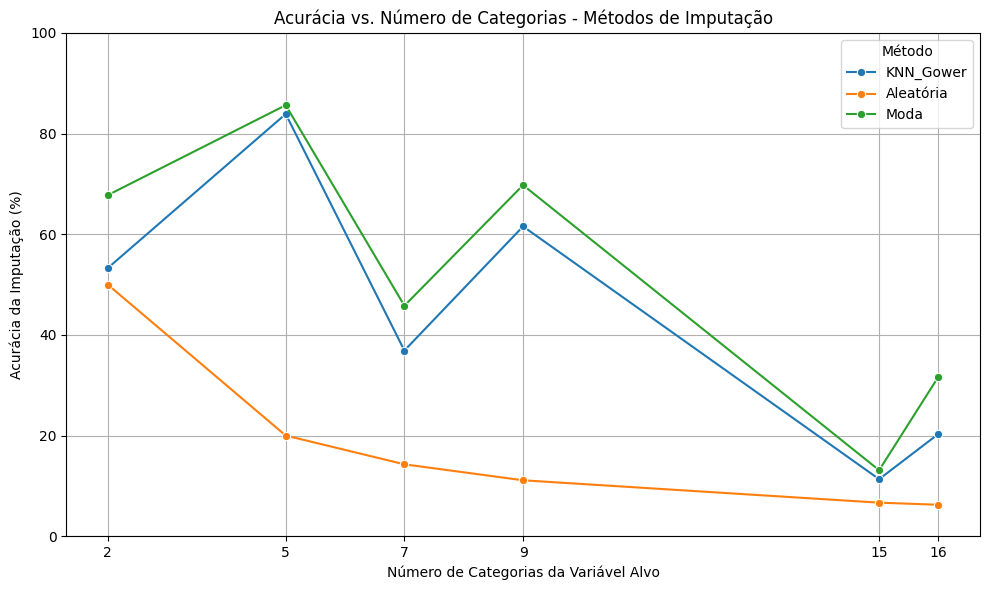

In [81]:
df_results = pd.DataFrame(results)

# Gráfico de linhas com número de categorias no eixo X
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_results, x='num_categorias', y='acuracia', hue='metodo', marker='o')

plt.title('Acurácia vs. Número de Categorias - Métodos de Imputação')
plt.xlabel('Número de Categorias da Variável Alvo')
plt.ylabel('Acurácia da Imputação (%)')
plt.ylim(0, 100)
plt.xticks(df_results['num_categorias'].unique())
plt.grid(True)
plt.tight_layout()
plt.legend(title='Método')
plt.show()